# 1. Introduction

A brief description of your approach to the problem and the results that you 
have obtained on the training data.

\*Insert Introduction here\*

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such 
a way that I can modify it to run on my own machine by simply changing the location 
of the training data and any additional data sources that you have used.

In [1]:
# I intend to use Data Frames to hold our data for now. When putting it in the model,
# I will probably have to change it to another format later but that is a problem for future me, not current me
# (Im joking; please dont deduct points, Mr/Ms Marker)
# Seriously though, Data Frames have very good performance and are malleable for data investigation,
# hence my decision to use them.

import pandas as pd
from pandas import DataFrame as df
import csv

def dataframe_from_diabetic_data_csv(csv_filepath):
    return pd.read_csv(csv_filepath)

TRAINING_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_training.csv"
TEST_DATA_FILEPATH = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/diabetic_data_test.csv"

training_data = dataframe_from_diabetic_data_csv(TRAINING_DATA_FILEPATH)
test_data = dataframe_from_diabetic_data_csv(TEST_DATA_FILEPATH)

print(training_data)



       encounter_id  patient_nbr             race  gender      age weight  \
0            149190     55629189        Caucasian  Female  [10-20)      ?   
1             64410     86047875  AfricanAmerican  Female  [20-30)      ?   
2            500364     82442376        Caucasian    Male  [30-40)      ?   
3             16680     42519267        Caucasian    Male  [40-50)      ?   
4             35754     82637451        Caucasian    Male  [50-60)      ?   
...             ...          ...              ...     ...      ...    ...   
91584     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
91585     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
91586     443854148     41088789        Caucasian    Male  [70-80)      ?   
91587     443857166     31693671        Caucasian  Female  [80-90)      ?   
91588     443867222    175429310        Caucasian    Male  [70-80)      ?   

       admission_type_id  discharge_disposition_id  admission_source_id  \


# 3. Data Transformation and Exploration
Code for the equivalent section in your report, together with in-line documentation of 
that code.

In [2]:
# I'm going to create some helper functions that might become useful in future.
# Using a few dictionaries I'll allow for mapping from discharge IDs, admission type IDs,
# and admission source IDs, to their true meaning


id_mapping_file_path = "BENG0095 (202425) Group Coursework Brief-20251122/Dataset/IDS_mapping.csv"
admission_type_ids = {}
discharge_ids = {}
admission_source_ids = {}

with open(id_mapping_file_path, newline = '') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in csvreader:
        if row[0] == 'admission_type_id':
            current_dictionary = 'AT'
        elif row[0] == 'discharge_disposition_id':
            current_dictionary = 'DD'
        elif row[0] == 'admission_source_id':
            current_dictionary = 'AS'
        elif row[0] == '':
            continue
        elif current_dictionary == 'AT':
            admission_type_ids[int(row[0])] = row[1]
        elif current_dictionary == 'DD':
            discharge_ids[int(row[0])] = row[1]
        else:
            admission_source_ids[int(row[0])] = row[1]
        
def get_admission_type(admission_type_id):
    try:
        return admission_type_ids[admission_type_id]
    except:
        return 'INVALID ADMISSION TYPE ID'

def get_discharge_type(discharge_id):
    try:
        return discharge_ids[discharge_id]
    except:
        return 'INVALID DISCHARGE ID'

def get_admission_source_ids(admission_source_id):
    try:
        return admission_source_ids[admission_source_id]
    except:
        return 'INVALID ADMISSION SOURCE ID'

#print(admission_type_ids)
#print(discharge_ids)
#print(admission_source_ids)

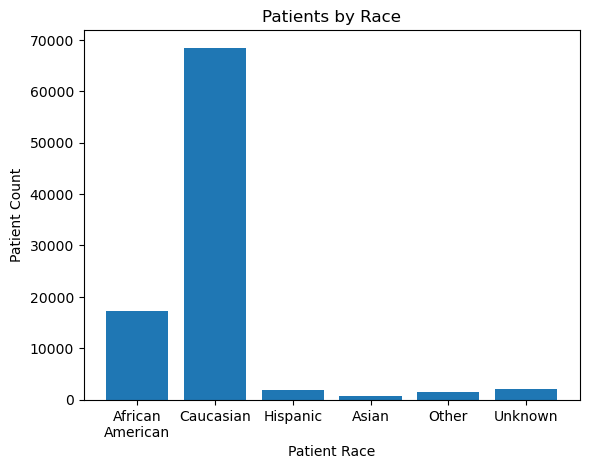

In [3]:
# I want to create some data visualisations that can provide some insights.
# I intend to use these insights to inform how I set up the model's architecture

import matplotlib
from matplotlib import pyplot as plt

# Grouping Patients by Race
african_americans = training_data[training_data['race']=='AfricanAmerican']
african_american_patients = len(african_americans)

caucasians = training_data[training_data['race'] == 'Caucasian']
caucasian_patients = len(caucasians)

hispanics = training_data[training_data['race'] == 'Hispanic']
hispanic_patients = len(hispanics)

asians = training_data[training_data['race'] == 'Asian']
asian_patients = len(asians)

others = training_data[training_data['race'] == 'Other']
other_race_patients = len(others)

unknowns = training_data[training_data['race'] == '?']
unknown_race_patients = len(unknowns)

races = ['African\nAmerican', 'Caucasian', 'Hispanic', 'Asian', 'Other', 'Unknown']
patient_counts = [african_american_patients, caucasian_patients, hispanic_patients, asian_patients, other_race_patients, unknown_race_patients]

plt.bar(races, patient_counts)
plt.title("Patients by Race")
plt.xlabel("Patient Race")
plt.ylabel("Patient Count")
plt.show()

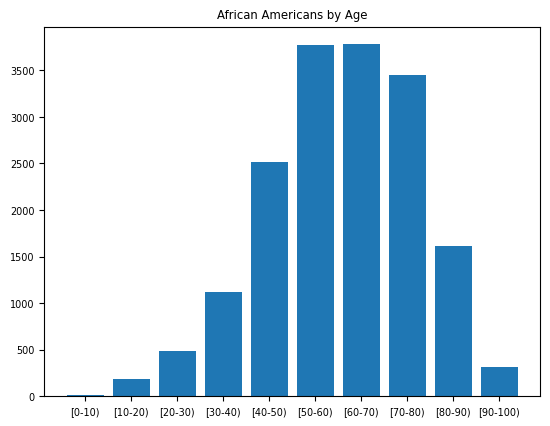

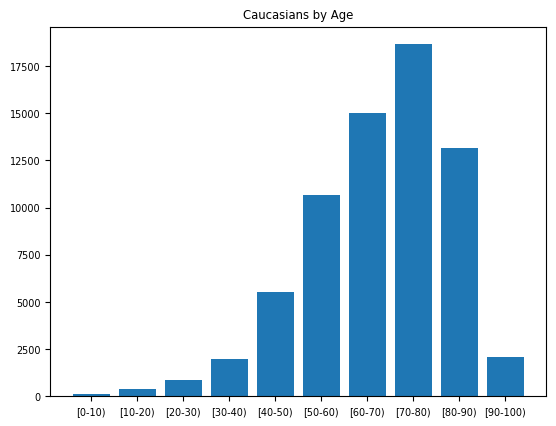

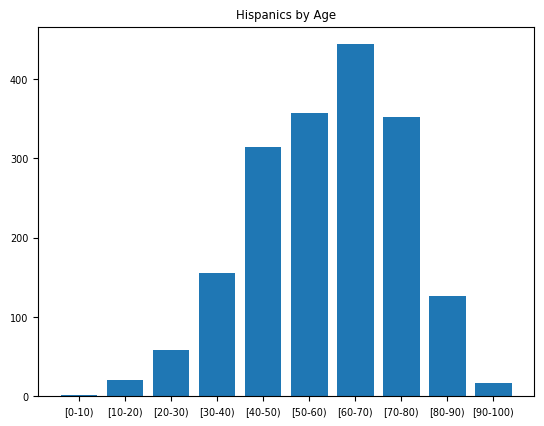

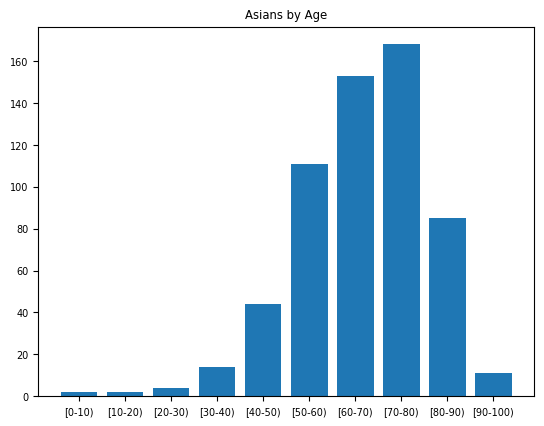

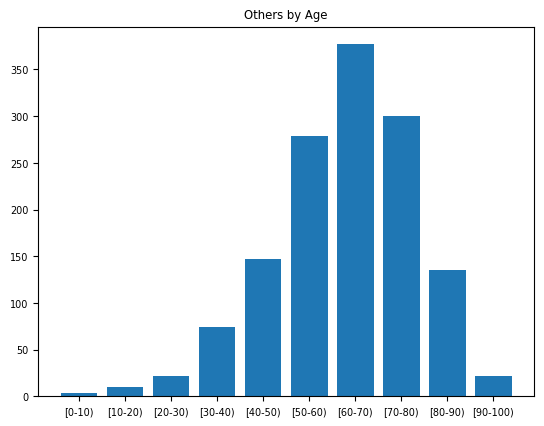

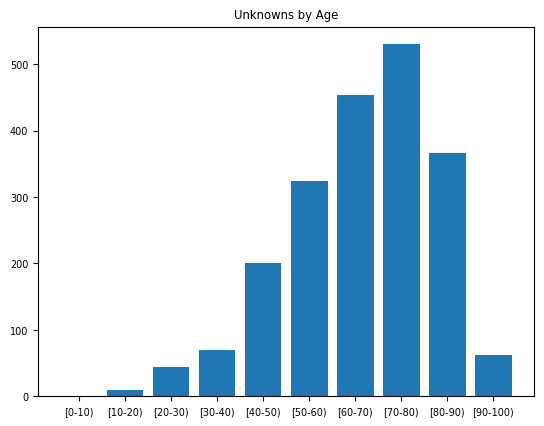

In [4]:
# Grouping patients by age within race
# '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[80-90)' '[90-100)' '[0-10)'
age_brackets = ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']
african_americans_by_age = [len(african_americans[african_americans['age'] == bracket]) for bracket in age_brackets]
caucasians_by_age = [len(caucasians[caucasians['age'] == bracket]) for bracket in age_brackets]
hispanics_by_age = [len(hispanics[hispanics['age'] == bracket]) for bracket in age_brackets]
asians_by_age = [len(asians[asians['age'] == bracket]) for bracket in age_brackets]
others_by_age = [len(others[others['age'] == bracket]) for bracket in age_brackets]
unknowns_by_age = [len(unknowns[unknowns['age'] == bracket]) for bracket in age_brackets]

plt.rcParams.update({'font.size': 7})

plt.bar(age_brackets, african_americans_by_age)
plt.title('African Americans by Age')
plt.show()

plt.bar(age_brackets, caucasians_by_age)
plt.title('Caucasians by Age')
plt.show()

plt.bar(age_brackets, hispanics_by_age)
plt.title('Hispanics by Age')
plt.show()

plt.bar(age_brackets, asians_by_age)
plt.title('Asians by Age')
plt.show()

plt.bar(age_brackets, others_by_age)
plt.title('Others by Age')
plt.show()

plt.bar(age_brackets, unknowns_by_age)
plt.title('Unknowns by Age')
plt.show()

plt.rcParams.clear()
# african_american_axes = plt.subplot(3, 3, 1)
# african_american_axes.bar(age_brackets, african_americans_by_age)
# african_american_axes.set_title('African Americans by Age', fontsize = 7)


# caucasian_axes = plt.subplot(3, 3, 2)
# caucasian_axes.bar(age_brackets, caucasians_by_age)
# caucasian_axes.set_title('Caucasians by Age', fontsize = 7)


# hispanic_axes = plt.subplot(3, 3, 3)
# hispanic_axes.bar(age_brackets, hispanics_by_age)
# hispanic_axes.set_title('Hispanics by Age', fontsize = 7)


# asian_axes = plt.subplot(3, 3, 4)
# asian_axes.bar(age_brackets, asians_by_age)
# asian_axes.set_title('Asians by Age', fontsize = 7)


# other_axes = plt.subplot(3, 3, 5)
# other_axes.bar(age_brackets, others_by_age)
# other_axes.set_title('Others by Age', fontsize = 7)


# unknown_axes = plt.subplot(3, 3, 6)
# unknown_axes.bar(age_brackets, unknowns_by_age)
# unknown_axes.set_title('Unknowns by Age', fontsize = 7)


# plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)

# plt.show()



1:  Physician Referral
2: Clinic Referral
3: HMO Referral
4: Transfer from a hospital
5:  Transfer from a Skilled Nursing Facility (SNF)
6:  Transfer from another health care facility
7:  Emergency Room
8:  Court/Law Enforcement
9:  Not Available
10:  Transfer from critial access hospital
11: Normal Delivery
13:  Sick Baby
14:  Extramural Birth
17: NULL
20:  Not Mapped
22:  Transfer from hospital inpt/same fac reslt in a sep claim
25:  Transfer from Ambulatory Surgery Center


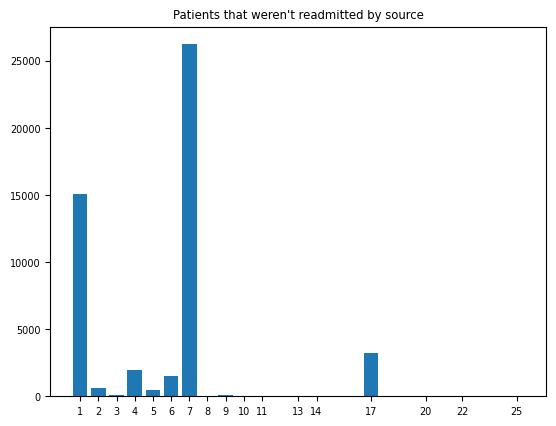

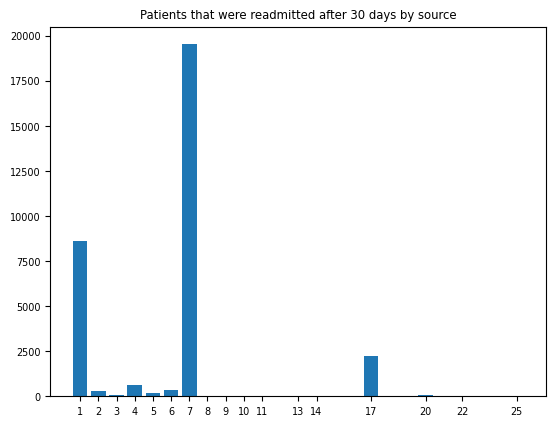

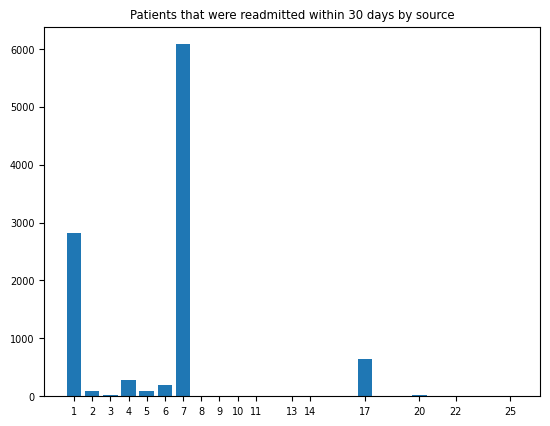

In [5]:
# Let's visualise the patient's outcome (readmittance) based on their admittance

patients_not_readmitted = training_data[training_data['readmitted'] == 'NO']
patients_readmitted_after_30_days = training_data[training_data['readmitted'] == '>30']
patients_readmitted_within_30_days = training_data[training_data['readmitted'] == '<30']

admission_sources = list(training_data['admission_source_id'].unique())
admission_sources.sort()

# Now that we have the patients separated by their outcome, lets visualise what made them go to the hospital
not_readmitted_patients_by_source = [len(patients_not_readmitted[patients_not_readmitted['admission_source_id'] == aso]) for aso in admission_sources]
readmitted_patients_after_30_days_by_source = [len(patients_readmitted_after_30_days[patients_readmitted_after_30_days['admission_source_id'] == aso]) for aso in admission_sources]
readmitted_patients_within_30_days_by_source = [len(patients_readmitted_within_30_days[patients_readmitted_within_30_days['admission_source_id'] == aso]) for aso in admission_sources]

for aso in admission_sources:
    print(f"{aso}: {get_admission_source_ids(aso)}")

plt.bar(admission_sources, not_readmitted_patients_by_source)
plt.title("Patients that weren't readmitted by source")
plt.xticks(admission_sources)
plt.show()
plt.bar(admission_sources, readmitted_patients_after_30_days_by_source)
plt.title("Patients that were readmitted after 30 days by source")
plt.xticks(admission_sources)
plt.show()
plt.bar(admission_sources, readmitted_patients_within_30_days_by_source)
plt.title("Patients that were readmitted within 30 days by source")
plt.xticks(admission_sources)
plt.show()




# print(len(patients_not_readmitted), len(patients_readmitted_after_30), len(patients_readmitted_within_30))

In [10]:
# cleaning and visualising for previous hospital encounters

df = pd.read_csv(TRAINING_DATA_FILEPATH)

cols = ["number_inpatient", "number_outpatient", "number_emergency"]

df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Replace NaN with 0 (patients often have no prior visits)
df[cols] = df[cols].fillna(0)

# Clip extreme outliers (very rare >10 visits)
df[cols] = df[cols].clip(0, 10)

df["total_visits"] = df["number_inpatient"] + df["number_outpatient"] + df["number_emergency"]

df[cols + ["total_visits"]]


,number_inpatient,number_outpatient,number_emergency,total_visits
0,0,0,0,0
1,1,2,0,3
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
91584,0,0,0,0
91585,1,0,0,1
91586,0,1,0,1
91587,1,0,0,1


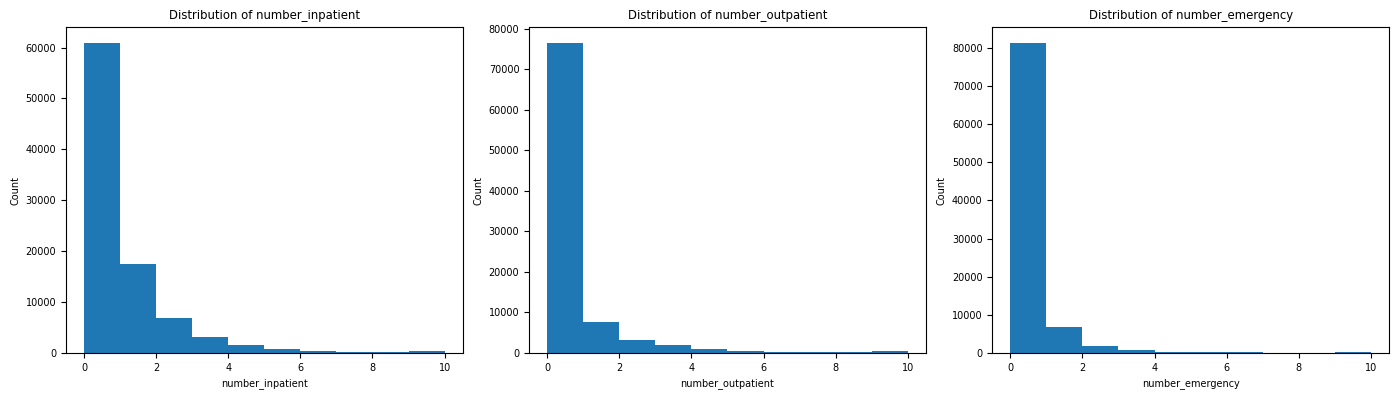

In [11]:
plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    plt.hist(df[col], bins=10)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

/var/folders/2_/cs6k5z6129j71cv3p08t5vym0000gn/T/ipykernel_11542/772264036.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(df[cols], labels=cols)


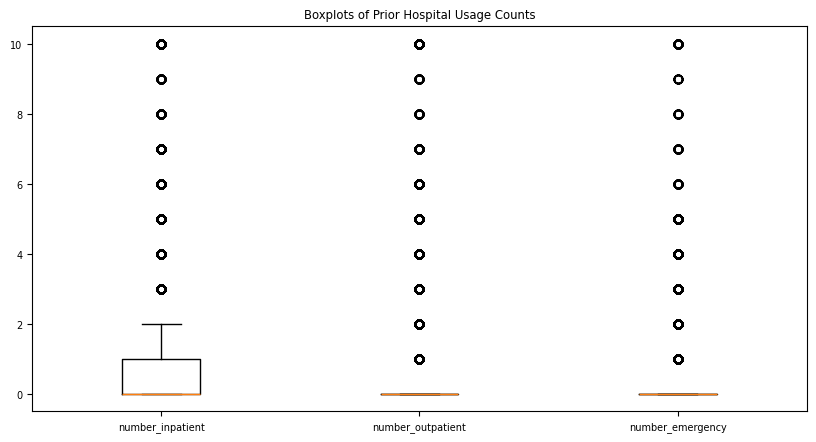

In [12]:
plt.figure(figsize=(10,5))
plt.boxplot(df[cols], labels=cols)
plt.title("Boxplots of Prior Hospital Usage Counts")
plt.show()


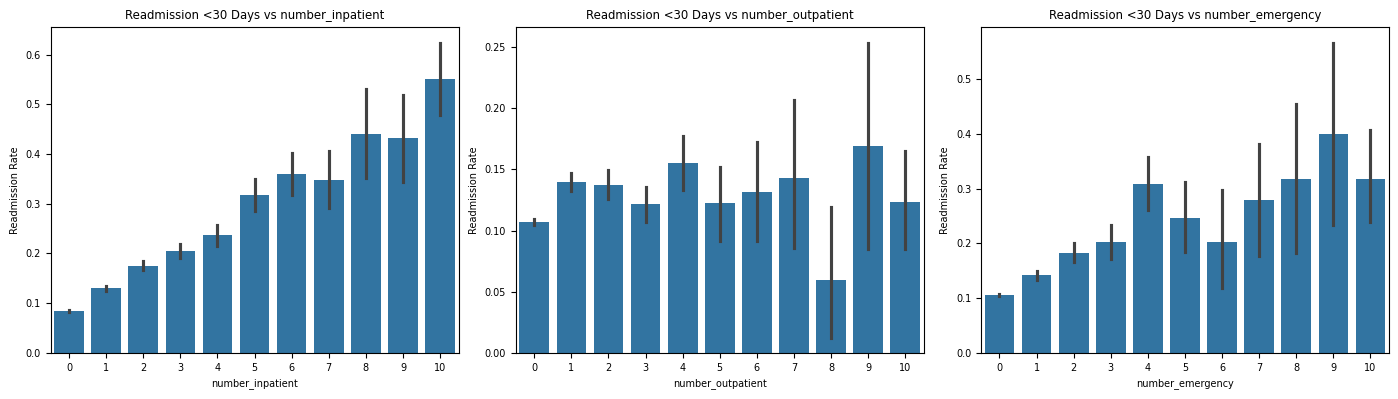

In [13]:
import seaborn as sns

plt.figure(figsize=(14,4))

for i, col in enumerate(cols):
    plt.subplot(1, 3, i+1)
    sns.barplot(x=df[col], y=(df["readmitted"]=="<30").astype(int))
    plt.title(f"Readmission <30 Days vs {col}")
    plt.ylabel("Readmission Rate")

plt.tight_layout()
plt.show()


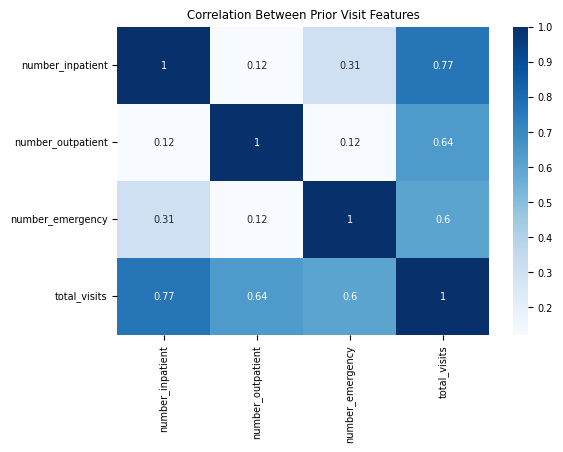

In [14]:
plt.figure(figsize=(6,4))
sns.heatmap(df[cols + ["total_visits"]].corr(), annot=True, cmap="Blues")
plt.title("Correlation Between Prior Visit Features")
plt.show()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (modify if needed)
df = pd.read_csv(TRAINING_DATA_FILEPATH)

# Columns to clean
encounter_cols = [
    "time_in_hospital",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id"
]

# Convert to numeric
df[encounter_cols] = df[encounter_cols].apply(pd.to_numeric, errors="coerce")

# Replace any NaN with a special category (rare)
df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]] = \
    df[["admission_type_id", "discharge_disposition_id", "admission_source_id"]].fillna(-1)

# Ensure time_in_hospital has no NaN
df["time_in_hospital"] = df["time_in_hospital"].fillna(df["time_in_hospital"].median())

df[encounter_cols].head()


,time_in_hospital,admission_type_id,discharge_disposition_id,admission_source_id
0,3,1,1,7
1,2,1,1,7
2,2,1,1,7
3,1,1,1,7
4,3,2,1,2


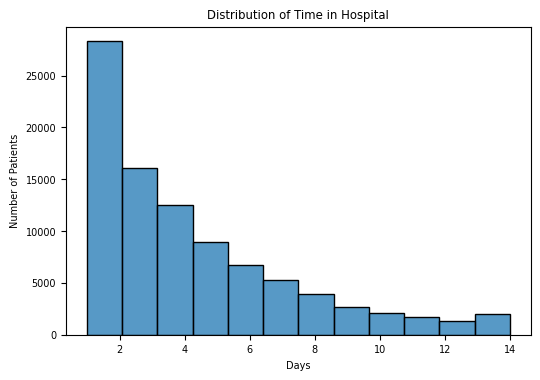

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(df["time_in_hospital"], bins=12, kde=False)
plt.title("Distribution of Time in Hospital")
plt.xlabel("Days")
plt.ylabel("Number of Patients")
plt.show()


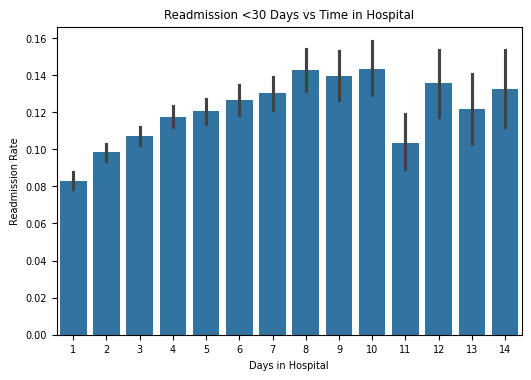

In [18]:
plt.figure(figsize=(6,4))
sns.barplot(x=df["time_in_hospital"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Time in Hospital")
plt.xlabel("Days in Hospital")
plt.ylabel("Readmission Rate")
plt.show()


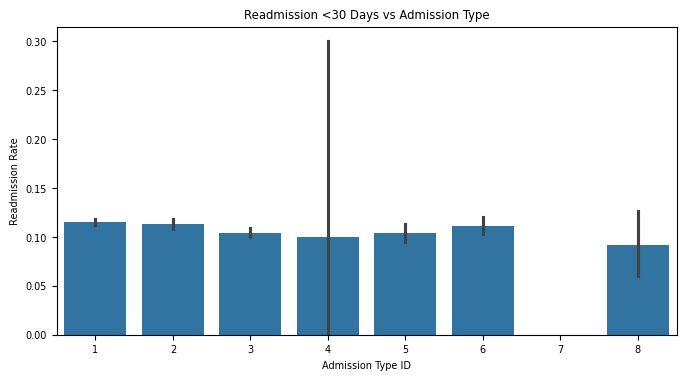

In [19]:
plt.figure(figsize=(8,4))
sns.barplot(x=df["admission_type_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Type")
plt.xlabel("Admission Type ID")
plt.ylabel("Readmission Rate")
plt.show()


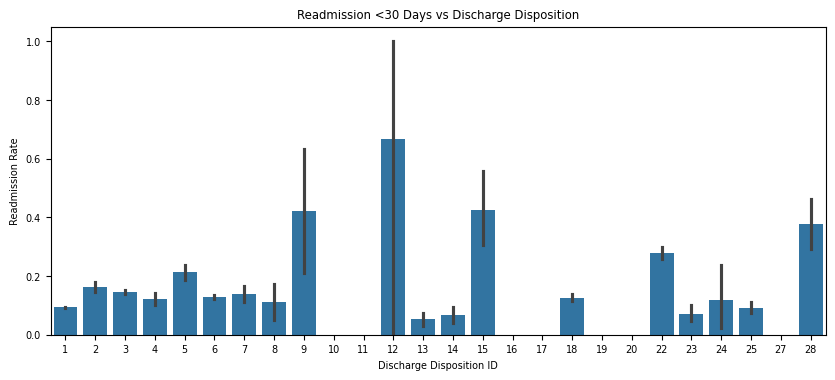

In [20]:
plt.figure(figsize=(10,4))
sns.barplot(x=df["discharge_disposition_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Discharge Disposition")
plt.xlabel("Discharge Disposition ID")
plt.ylabel("Readmission Rate")
plt.show()


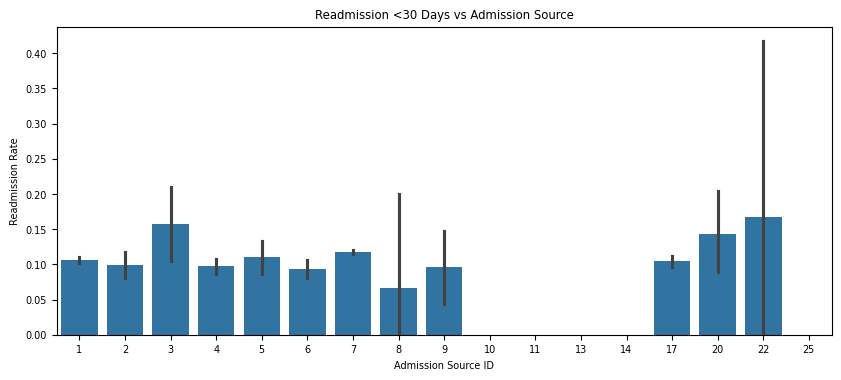

In [21]:
plt.figure(figsize=(10,4))
sns.barplot(x=df["admission_source_id"], 
            y=(df["readmitted"]=="<30").astype(int))
plt.title("Readmission <30 Days vs Admission Source")
plt.xlabel("Admission Source ID")
plt.ylabel("Readmission Rate")
plt.show()


# 4. Methodology Overview
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 5. Model Training & Validation
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 6. Results
Code for the equivalent section in your report, together with in-line documentation of 
that code.

# 7. Final Predictions on Test Set
Code for the equivalent section in your report, together with in-line documentation of 
that code.